In [1]:
from qiskit import *
from qiskit.providers.aer.noise import *

from qiskit.test.mock import FakeVigo

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from numpy import *

from zero_noise_extrapolation_cnot import ZeroNoiseExtrapolation

import matplotlib.pyplot as plt
%matplotlib inline

sim_backend = Aer.get_backend("qasm_simulator")
mock_backend = FakeVigo()

In [2]:
def add_swap_gate(qc, probe, q1, q2, barrier=False):
    qc.toffoli(probe, q1, q2)
    
    if barrier:
        qc.barrier()
        
    qc.toffoli(probe, q2, q1)
    
    if barrier:
        qc.barrier()
    
    qc.toffoli(probe, q1, q2)
    
def create_3qswaptest_circuit(barrier=False):
    qc = QuantumCircuit(3,1)
    
    qc.h(0)
    
    qc.h(1)
    
    if barrier:
        qc.barrier()
    
    add_swap_gate(qc, 0, 1, 2, barrier=barrier)
    
    if barrier:
        qc.barrier()
    
    qc.h(0)
    
    qc.measure(0,0)
    
    return qc

The SWAP-test circuit on two 1-qubit states is constructed as shown belown, using 3 Toffoli-gates. https://arxiv.org/abs/1712.09271

The states prepared on q_1 = (|0> + |1>)/sqrt(2) and q_2 = |0> are swaped, while q_0 acts as a probe qubit. The Z-measurement on the probe qubit measures the overlap between the two swapped states. The true value in this case is 0.5.

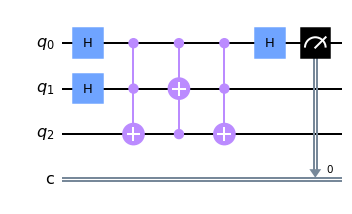

In [3]:
qc = create_3qswaptest_circuit()

qc.draw(output="mpl")

Each Toffoli-gate can be decomposed in the following way. Note that one Toffoli gate has a CNOT complexity of 6

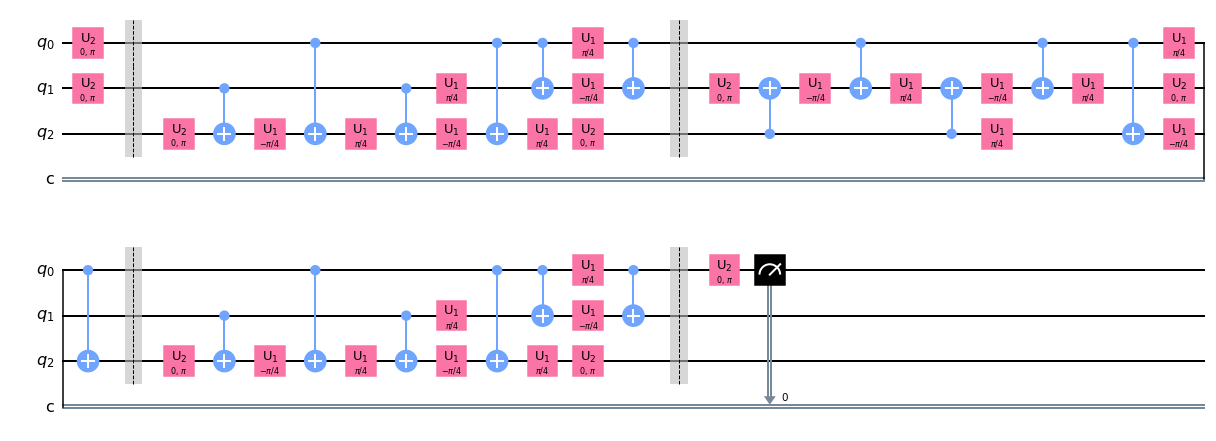

In [4]:
pass_manager = PassManager(Unroller(["u1","u2","u3","cx"]))

qc_swap = create_3qswaptest_circuit(barrier=True)

qc_unrolled = pass_manager.run(qc_swap)

qc_unrolled.draw(output="mpl")

In [5]:
# Function which computes expectation value of the Z-measurement on the 3q SWAP-test circuit based on measurement counts
def swaptest_exp_val_func(counts: dict) -> float:
    exp_val = 0
    tot = 0
    for key in counts.keys():
        if key.count("1") % 2 == 0:
            eigenval = +1
        else:
            eigenval = -1
        exp_val += counts[key]*eigenval
        tot += counts[key]
    return exp_val / tot

Zero noise extrapolation, mitigating noise on CNOT-gates, on the SWAP-test circuit. Executing the circuits on a simulator with a stochastic Pauli noise model. We choose the noise probability on CNOT-gates to be an order of magnitude larger than on the u1/u2/u3 single-qubit gates.

Noise amplification factors = [1,3,5,7,9]

In [6]:
p_cnot = 5e-3
p_u = 5e-4

bit_flip_cnot = pauli_error([('X',p_cnot),('I',1-p_cnot)])
phase_flip_cnot = pauli_error([('Z',p_cnot),('I',1-p_cnot)])

pauli_error_cnot = bit_flip_cnot.compose(phase_flip_cnot)
cnot_error = pauli_error_cnot.tensor(pauli_error_cnot)

bit_flip_u = pauli_error([('X',p_u),('I',1-p_u)])
phase_flip_u = pauli_error([('Z',p_u),('I',1-p_u)])

pauli_error_u = bit_flip_u.compose(phase_flip_u)

NOISE_MODEL = NoiseModel()
NOISE_MODEL.add_all_qubit_quantum_error(cnot_error, ["cx"])
NOISE_MODEL.add_all_qubit_quantum_error(pauli_error_u, ["u1","u2","u3"])

N_AMP_FACTORS = 5 # -> amplification_factors = [1,3,5,7,9]
SHOTS = 20*8192

qem = ZeroNoiseExtrapolation(qc=qc, exp_val_func=swaptest_exp_val_func, backend=sim_backend, noise_model=NOISE_MODEL,
                             n_amp_factors=N_AMP_FACTORS, shots=SHOTS)

qem.mitigate(verbose=True)

print(qem.result)

shots=7801, n_amp_factors=5, paulitwirl=False, repeats=1
noise amplification factors=[1 3 5 7 9]
Constructing circuits
Depths=[ 35.  71. 107. 143. 179.]
Executing circuits
Processing results
Mitigation done. Result:
Bare exp val = 0.3547225325202508
Mitigated exp val = 0.46828636514854505
0.46828636514854505


Zero noise extrapolation, mitigating noise on CNOT-gates, on the SWAP-test circuit. Now on the mock backend FakeVigo, which emulates IBMQ's Vigo quantum device.

Noise amplification factors = [1,3,5,7,9]

In [7]:
N_AMP_FACTORS = 5 # -> amplification_factors = [1,3,5,7,9]
SHOTS = 20*8192

qem = ZeroNoiseExtrapolation(qc=qc, exp_val_func=swaptest_exp_val_func, backend=mock_backend, 
                             n_amp_factors=N_AMP_FACTORS, shots=SHOTS)

qem.mitigate(verbose=True)

print(qem.result)

shots=7801, n_amp_factors=5, paulitwirl=False, repeats=1
noise amplification factors=[1 3 5 7 9]
Constructing circuits
Depths=[ 48.  98. 148. 198. 248.]
Executing circuits
Processing results
Mitigation done. Result:
Bare exp val = 0.39570628918148465
Mitigated exp val = 0.47859391881993063
0.47859391881993063


Investigate the convergence of the zero-noise extrapolation with amplification factors [1,3,5], run on mock backend FakeVigo.

Mitigated exp val = 0.45471598307291666


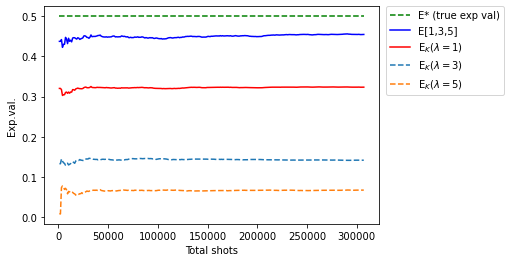

In [8]:
N_AMP_FACTORS = 3 # -> amplification_factors = [1,3,5]
REPEATS = 300
SHOTS_PER_REPEAT = 1024
PAULI_TWIRL = False

qem = ZeroNoiseExtrapolation(qc=qc, exp_val_func=swaptest_exp_val_func, backend=mock_backend, n_amp_factors=N_AMP_FACTORS,
                             pauli_twirl=PAULI_TWIRL, shots=SHOTS_PER_REPEAT)

# Do several repeats to investigate the convergence as a function of total executed shots:
qem.mitigate(repeats=REPEATS)

total_shots = linspace(SHOTS_PER_REPEAT, REPEATS*SHOTS_PER_REPEAT, REPEATS, dtype=int, endpoint=True)

true_exp_val = zeros(REPEATS) + 0.5

mitigated_exp_val_as_func_of_shots = zeros(REPEATS)
bare_exp_val_as_func_of_shots = zeros(REPEATS)
lambda3_exp_val_as_func_of_shots = zeros(REPEATS)
lambda5_exp_val_as_func_of_shots = zeros(REPEATS)

mitigated_exp_val_as_func_of_shots[0] = qem.mitigated_exp_vals[0]
bare_exp_val_as_func_of_shots[0] = qem.bare_exp_vals[0]
lambda3_exp_val_as_func_of_shots[0] = qem.all_exp_vals[0,1]
lambda5_exp_val_as_func_of_shots[0] = qem.all_exp_vals[0,2]

for i in range(1,REPEATS):
    mitigated_exp_val_as_func_of_shots[i] = average(qem.mitigated_exp_vals[0:i])
    bare_exp_val_as_func_of_shots[i] = average(qem.bare_exp_vals[0:i])
    
    lambda3_exp_val_as_func_of_shots[i] = average(qem.all_exp_vals[0:i,1])
    lambda5_exp_val_as_func_of_shots[i] = average(qem.all_exp_vals[0:i,2])

plt.plot(total_shots, true_exp_val, "g--",label="E* (true exp val)")
plt.plot(total_shots, mitigated_exp_val_as_func_of_shots, "b-",label="E[1,3,5]")

plt.plot(total_shots, bare_exp_val_as_func_of_shots, "r-", label=r"E$_K (\lambda = 1)$")
plt.plot(total_shots, lambda3_exp_val_as_func_of_shots,'--', label=r"E$_K (\lambda = 3)$")
plt.plot(total_shots, lambda5_exp_val_as_func_of_shots,'--',  label=r"E$_K (\lambda = 5)$")

plt.xlabel("Total shots")
plt.ylabel("Exp.val.")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

print("Mitigated exp val =",qem.result)

In [ ]:
qiskit.__qiskit_version__